In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from torchvision import models, transforms

In [3]:
from zse.models.adain_module import AdaINLitModule2D
from zse.models.components.adain_net import AdaINNet
from zse.models.components.adain_unet import AdaINUNet
from zse.models.components.unet import UNet

In [4]:
def get_psf(kernel_size, r):
    # rows, cols, channels = img.shape
    # m = cv2.getOptimalDFTSize(rows)
    # n = cv2.getOptimalDFTSize(cols)
    # size = (m, n)
    size = (kernel_size, kernel_size)
    h = np.zeros(size, dtype=np.float32)
    cv2.circle(h, (size[1] // 2, size[0] // 2), r, 1, -1)
    psf = h / np.sum(h)
    cv2.destroyAllWindows()
    return psf

In [5]:
def plot(img, path, title=None):
    img = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    plt.figure(dpi=100)
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.imsave(path, img, vmin=0, vmax=1)

In [6]:
home = "/p/fastdata/bigbrains/personal/crijnen1"
data_root = f"{home}/data"
zse_path = f"../.."
model_path = f"{zse_path}/models/leishmania"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
dest = f"{zse_path}/reports/results/leishmania/generalization"

In [8]:
vgg19 = models.vgg19(pretrained=True)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
adain_unet = AdaINUNet(vgg19, norm, out_channels=3)
adain = AdaINNet(vgg19, norm, out_channels=3)
unet = UNet(vgg19, norm, in_channels=3, out_channels=3)

# ID 11072

In [9]:
path = f"{data_root}/leishmania_generalization/11072.tif"
to_tensor = transforms.ToTensor()
sharp_img = cv2.imread(path)
sharp_img = cv2.resize(sharp_img, dsize=(512, 512))
blurry_img = gaussian(sharp_img, sigma=(2, 2), truncate=3.5, channel_axis=2, preserve_range=True).astype(np.uint8)
sharp_img = to_tensor(sharp_img).unsqueeze(0)
blurry_img = to_tensor(blurry_img).unsqueeze(0)

In [10]:
# psf = get_psf(kernel_size=11, r=3)
# psf = np.stack([psf, psf, psf], axis=2)
# blurry_img = signal.convolve(sharp_image, psf, "same")
# print(blurry_img.min(), blurry_img.max())

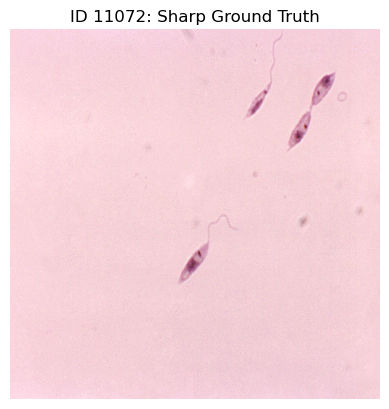

In [11]:
plot(sharp_img, f"{dest}/11072_sharp.png", "ID 11072: Sharp Ground Truth")

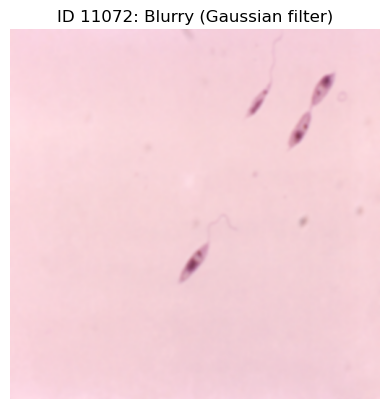

In [12]:
plot(blurry_img, f"{dest}/11072_blurry.png", "ID 11072: Blurry (Gaussian filter)")

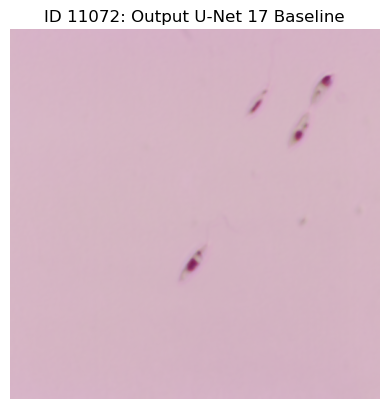

In [13]:
ckpt_path = f"{model_path}/unet/stats/lr:0.0001-beta:100.0_best.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
module.cpu()
plot(out, f"{dest}/11072_unet.png", "ID 11072: Output U-Net 17 Baseline") # , f"{dest}/u17_adain.png"

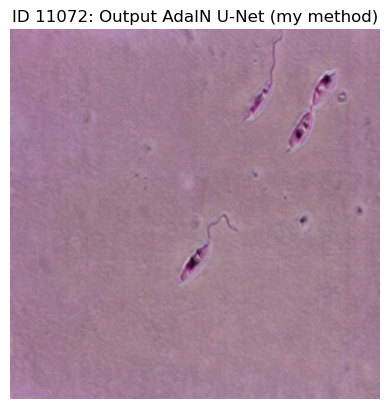

In [14]:
ckpt_path = f"{model_path}/adain_unet/gram/lr:0.001-beta:1000000.0_best.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain_unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
module.cpu()
plot(out, f"{dest}/11072_adain_unet.png", "ID 11072: Output AdaIN U-Net (my method)") # , f"{dest}/adain_unet_gram.png"

# ID 11074

In [15]:
path = f"{data_root}/leishmania_generalization/11074.tif"
to_tensor = transforms.ToTensor()
sharp_img2 = cv2.imread(path)
sharp_img2 = cv2.resize(sharp_img2, dsize=(512, 512))
blurry_img2 = gaussian(sharp_img2, sigma=(2, 2), truncate=3.5, channel_axis=2, preserve_range=True).astype(np.uint8)
sharp_img2 = to_tensor(sharp_img2).unsqueeze(0)
blurry_img2 = to_tensor(blurry_img2).unsqueeze(0)

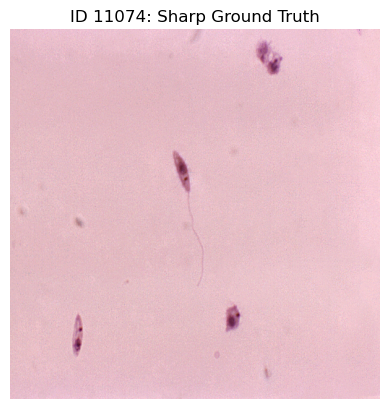

In [16]:
plot(sharp_img2, f"{dest}/11074_sharp.png", "ID 11074: Sharp Ground Truth")

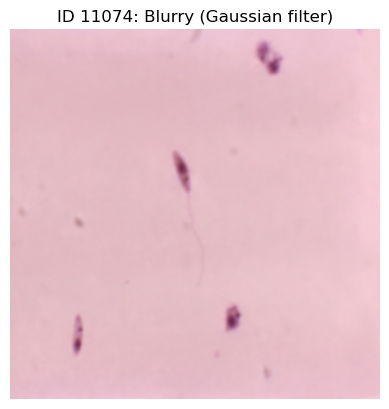

In [17]:
plot(blurry_img2, f"{dest}/11074_blurry.png", "ID 11074: Blurry (Gaussian filter)")

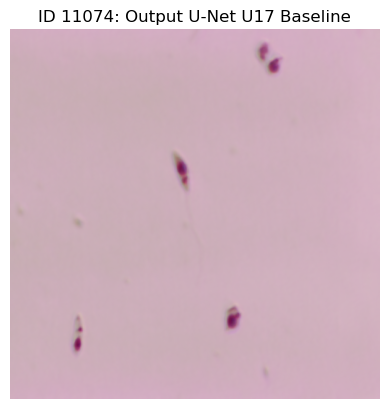

In [18]:
ckpt_path = f"{model_path}/unet/stats/lr:0.0001-beta:100.0_best.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img2.to(device), "style": sharp_img2.to(device)})
module.cpu()
plot(out, f"{dest}/11074_unet.png", "ID 11074: Output U-Net U17 Baseline") # , f"{dest}/u17_adain.png"

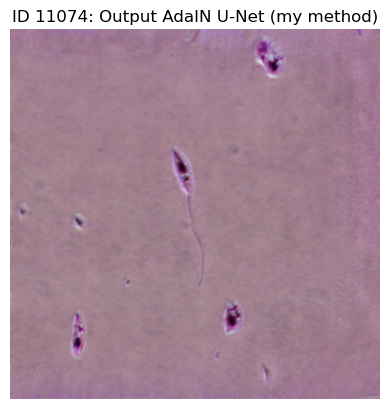

In [19]:
ckpt_path = f"{model_path}/adain_unet/gram/lr:0.001-beta:1000000.0_best.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain_unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img2.to(device), "style": sharp_img2.to(device)})
module.cpu()
plot(out, f"{dest}/11074_adain_unet.png", "ID 11074: Output AdaIN U-Net (my method)") # , f"{dest}/adain_unet_gram.png"